<a href="https://colab.research.google.com/github/fabianlae/Predict-H1N1-and-Seasonal-Flu-Vaccines/blob/main/Flushot_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daten einlesen

In [5]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

os.environ['TZ'] = 'Europe/Berlin'
time.tzset()

pd.set_option("display.max_columns", 100) # Display more dataframe columns in Jupyter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Root directory for Vincent's Google Drive 
# path = '/content/drive/MyDrive/data-flu-shot/data/'
# Root directory for Fabian's Google Drive 
path = '/content/drive/MyDrive/Flu_challenge/Predict-H1N1-and-Seasonal-Flu-Vaccines/data/'
root_dir=path+"raw/"

features_df = pd.read_csv(
    root_dir + 'training_set_features.csv', 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    root_dir + 'training_set_labels.csv', 
    index_col="respondent_id"
)
test_df = pd.read_csv(
    root_dir + 'test_set_features.csv', 
    index_col="respondent_id"
)

# Get labels
h1n1_label = np.asarray(labels_df['h1n1_vaccine'])
seasonal_label = np.asarray(labels_df['seasonal_vaccine'])

In [ ]:
print("features_df.shape", features_df.shape)
features_df.head()

features_df.shape (26707, 35)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [ ]:
features_df.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [ ]:
print("labels_df.shape", labels_df.shape)
labels_df.head()

labels_df.shape (26707, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [ ]:

np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

# Analytics



## Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [ ]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [ ]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

## One Hot Encoding

In [ ]:
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder


In [ ]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
object_cols = features_df.columns[features_df.dtypes == "object"].values

In [ ]:
#neues_df = df[numerische spalten].fillna(df.mean(), inplace=True)
features_df_num=features_df[numeric_cols].fillna(features_df.median(),inplace=False)

In [ ]:
features_df_obj=features_df[object_cols].fillna(features_df.mode().iloc[0])

In [ ]:
# features_df_preprocessed=features_df_num.merge(features_df_num_obj,how='inner',on='respondent_id')
# features_df_preprocessed

In [ ]:
rows = []
for index, row in features_df_num.iterrows():
  rows.append(row.to_numpy(dtype='int'))
features_array_num = np.asarray(rows)

rows = []
for index, row in features_df_obj.iterrows():
  rows.append(row)
features_array_obj = np.asarray(rows)

In [ ]:
enc=OneHotEncoder(handle_unknown='ignore')
enc.fit(features_array_obj)
enc.categories_

[array(['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years',
        '65+ Years'], dtype=object),
 array(['12 Years', '< 12 Years', 'College Graduate', 'Some College'],
       dtype=object),
 array(['Black', 'Hispanic', 'Other or Multiple', 'White'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['<= $75,000, Above Poverty', '> $75,000', 'Below Poverty'],
       dtype=object),
 array(['Married', 'Not Married'], dtype=object),
 array(['Own', 'Rent'], dtype=object),
 array(['Employed', 'Not in Labor Force', 'Unemployed'], dtype=object),
 array(['atmpeygn', 'bhuqouqj', 'dqpwygqj', 'fpwskwrf', 'kbazzjca',
        'lrircsnp', 'lzgpxyit', 'mlyzmhmf', 'oxchjgsf', 'qufhixun'],
       dtype=object),
 array(['MSA, Not Principle  City', 'MSA, Principle City', 'Non-MSA'],
       dtype=object),
 array(['arjwrbjb', 'atmlpfrs', 'cfqqtusy', 'dotnnunm', 'fcxhlnwr',
        'haxffmxo', 'ldnlellj', 'mcubkhph', 'mfikgejo', 'msuufmds',
        'nduyfdeo', 'phxvnwax', 'pxcmv

In [ ]:
encoded_features_array=enc.transform(features_array_obj).toarray()
encoded_features_array

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
final_features_array=np.column_stack((features_array_num,encoded_features_array))

In [ ]:
final_features_array.shape

(26707, 105)

In [ ]:
def preproc(features, imputation=True, OHE=True):
  '''
    Preprocessing for feature data comprising imputation and One Hot Encoding
  '''
  if imputation:
    # split features in numeric and categorical
    numeric_cols = features.columns[features.dtypes != "object"].values
    object_cols = features.columns[features.dtypes == "object"].values

    # impute data
    features_num_imputed = features[numeric_cols].fillna(features.median(),inplace=False)
    features_obj_imputed = features[object_cols].fillna(features.mode().iloc[0])

    # create arrays
    rows = []
    for index, row in features_num_imputed.iterrows():
      rows.append(row.to_numpy(dtype='int'))
    features_num_array = np.asarray(rows)

    rows = []
    for index, row in features_obj_imputed.iterrows():
      rows.append(row)
    features_obj_array = np.asarray(rows)

  if OHE:
    # One Hot Encode categorical values
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(features_obj_array)
    encoded_features_array = enc.transform(features_obj_array).toarray()
    # merge categorical and numerical data
    final_features_array = np.column_stack((features_num_array, encoded_features_array))
    print(final_features_array.shape)
    
    return final_features_array

In [ ]:
features_train = preproc(features=features_df)
features_test = preproc(features=test_df)

(26707, 105)
(26708, 105)


In [ ]:
X_train_h1n1, X_eval_h1n1, y_train_h1n1, y_eval_h1n1 = train_test_split(features_train, h1n1_label, test_size=0.2, random_state=42)
X_train_seasonal, X_eval_seasonal, y_train_seasonal, y_eval_seasonal = train_test_split(features_train, seasonal_label, test_size=0.2, random_state=42)

## SVM

In [ ]:
clf = svm.SVR(kernel='poly', verbose=True, degree=3)
clf.fit(X_train_h1n1, y_train_h1n1)

[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [ ]:
pred = clf.predict(X_eval_h1n1)

In [57]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    # print(thresholds)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

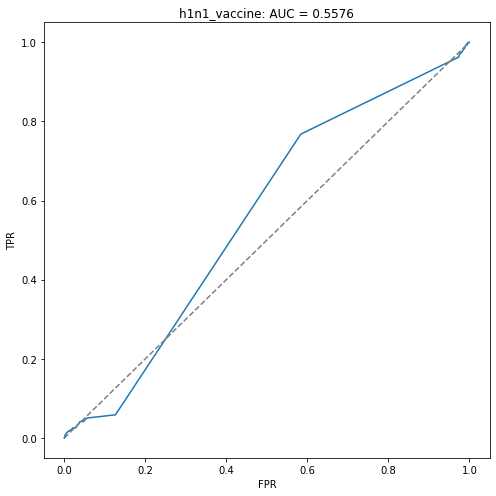

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval_h1n1, 
    pred, 
    'h1n1_vaccine',
    ax=ax
)
# plot_roc(
#     y_eval['seasonal_vaccine'], 
#     y_preds['seasonal_vaccine'], 
#     'seasonal_vaccine',
#     ax=ax[1]
# )
fig.tight_layout()

## Regressor

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr_h1n1 = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=500, verbose=True)
regr_seasonal = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=500, verbose=True)

regr_h1n1.fit(X_train_h1n1, y_train_h1n1)
regr_seasonal.fit(X_train_seasonal, y_train_seasonal)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   27.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   27.0s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=0, verbose=True, warm_start=False)

In [ ]:
# pred_h1n1 = regr.predict(X_eval)
pred_seasonal = regr_seasonal.predict(X_eval_seasonal)
pred_h1n1 = regr_h1n1.predict(X_eval_h1n1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


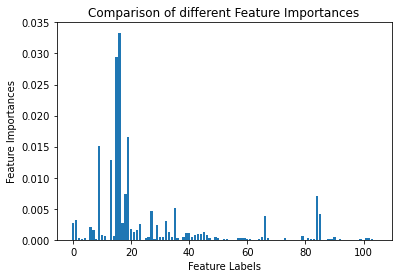

In [ ]:
# Feature importance

# Computing the importance of each feature
feature_importance = regr_h1n1.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        regr_h1n1.estimators_],
                                        axis = 0)

# Plotting a Bar Graph to compare the models
plt.bar(np.arange(0, 105), feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [ ]:
sum(feature_importance_normalized>0.005)
# np.arange(0, 105)

8

In [ ]:
features_df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

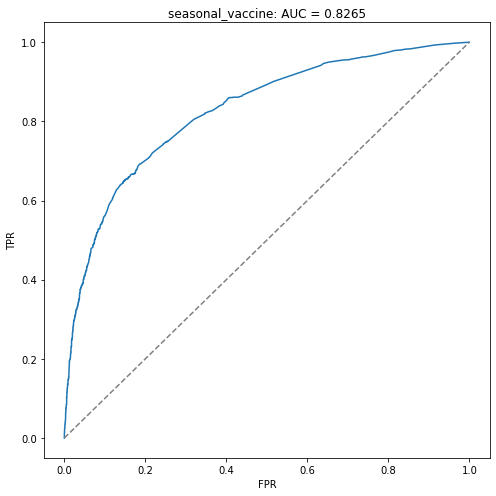

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval_h1n1, 
    pred_h1n1, 
    'seasonal_vaccine',
    ax=ax
)
# plot_roc(
#     y_eval['seasonal_vaccine'], 
#     y_preds['seasonal_vaccine'], 
#     'seasonal_vaccine',
#     ax=ax[1]
# )
fig.tight_layout()

### Gradien Boost Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

GBR_h1n1 = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.05, random_state=42, verbose=1)
GBR_seasonal = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.05, random_state=42, verbose=1)
GBR_h1n1.fit(X_train_h1n1, y_train_h1n1)
GBR_seasonal.fit(X_train_seasonal, y_train_seasonal)
#>>> reg.predict(X_test[1:2])

      Iter       Train Loss   Remaining Time 
         1           0.1636            3.18m
         2           0.1601            3.55m
         3           0.1569            3.36m
         4           0.1540            3.33m
         5           0.1513            3.21m
         6           0.1490            3.13m
         7           0.1468            3.06m
         8           0.1448            3.08m
         9           0.1430            3.11m
        10           0.1414            3.10m
        20           0.1308            2.96m
        30           0.1261            2.84m
        40           0.1233            2.72m
        50           0.1217            2.68m
        60           0.1205            2.63m
        70           0.1196            2.60m
        80           0.1189            2.57m
        90           0.1183            2.54m
       100           0.1179            2.51m
       200           0.1151            2.30m
       300           0.1136            2.15m
       40

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [ ]:
GBR_h1n1_pred = GBR_h1n1.predict(X_eval_h1n1)
GBR_h1n1_pred[:10]

array([ 0.13020301,  0.12329496, -0.00762182,  0.17914672,  0.18547148,
        0.82697641,  0.12197791,  0.4316429 ,  0.05561984,  0.6896908 ])

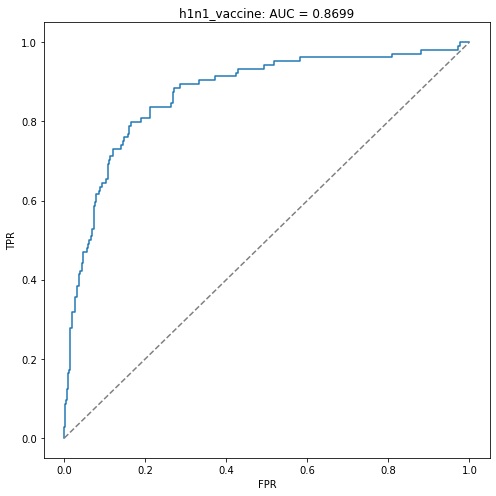

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval_h1n1, 
    GBR_h1n1_pred, 
    'h1n1_vaccine',
    ax=ax
)
# plot_roc(
#     y_eval['seasonal_vaccine'], 
#     y_preds['seasonal_vaccine'], 
#     'seasonal_vaccine',
#     ax=ax[1]
# )
fig.tight_layout()

### Try multiple models (algorithm evaluation)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def run_exps(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    
    models = [
          ('LogReg', LogisticRegression()), 
          # ('RF', RandomForestRegressor()),
          ('KNN', KNeighborsRegressor()),
          ('SVM', SVR()), 
          # ('GNB', GaussianNB()),
          ('XGB', XGBRegressor()),
          ('GBR', GradientBoostingRegressor())
        ]
        
    results = []
    names = []
    scoring = ['roc_auc', 'neg_root_mean_squared_error']
    # target_names = ['malignant', 'benign']


    for name, model in models:
      kfold = model_selection.KFold(n_splits=2, shuffle=True, random_state=90210)
      print(name)
      cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
      clf = model.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      print(name)
      # print(classification_report(y_test, y_pred, target_names=target_names))
        
      results.append(cv_results)
      names.append(name)

      this_df = pd.DataFrame(cv_results)
      this_df['model'] = name
      dfs.append(this_df)

    final = pd.concat(dfs, ignore_index=True)
        
    return final

In [ ]:
final = run_exps(X_train=X_train_h1n1, y_train= y_train_h1n1, X_test= X_eval_h1n1, y_test=y_eval_h1n1)
final
# final = run_exps(X_train=X_train, y_train= y_train, X_test= X_eval, y_test=y_eval)


LogReg


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

LogReg
KNN
KNN
SVM
SVM
XGB
[15:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
GBR
GBR


,fit_time,score_time,test_roc_auc,test_neg_root_mean_squared_error,model
0,0.366993,0.012707,0.835814,-0.401136,LogReg
1,0.392367,0.011682,0.830042,-0.410383,LogReg
2,0.247848,29.301175,0.726569,-0.388041,KNN
3,0.170934,27.685172,0.719848,-0.390943,KNN
4,14.446673,9.017820,0.820402,-0.350606,SVM
5,13.701899,8.809034,0.820907,-0.356843,SVM
6,2.486477,0.043067,0.835763,-0.343246,XGB
7,2.345628,0.043415,0.836385,-0.346385,XGB
8,3.186790,0.041985,0.836207,-0.343063,GBR
9,3.183827,0.034527,0.835875,-0.346522,GBR


### XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor

In [ ]:
X_train_h1n1.shape

(21365, 105)

In [ ]:
X_eval_h1n1.shape

X_train_h1n1_all = np.concatenate((X_train_h1n1, X_eval_h1n1), axis=0)
y_train_h1n1_all = np.concatenate((y_train_h1n1, y_eval_h1n1), axis=0)
X_train_seasonal_all = np.concatenate((X_train_seasonal, X_eval_seasonal), axis=0)
y_train_seasonal_all = np.concatenate((y_train_seasonal, y_eval_seasonal), axis=0)

print(X_train_h1n1_all.shape, y_train_h1n1_all.shape, X_train_seasonal_all.shape, y_train_seasonal_all.shape)

(26707, 105) (26707,) (26707, 105) (26707,)


In [ ]:
XGBR_h1n1 = XGBRegressor(learning_rate = 0.05745075659543725, max_depth=6, n_estimators=500, verbosity=1, objective='reg:squarederror')
XGBR_seasonal = XGBRegressor(learning_rate = 0.05745075659543725, max_depth=6, n_estimators=500, verbosity=1, objective='reg:squarederror')
XGBR_h1n1.fit(X_train_h1n1_all, y_train_h1n1_all)
XGBR_seasonal.fit(X_train_seasonal_all, y_train_seasonal_all)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05745075659543725,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
             n_estimators=500, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [ ]:
# scores from hyperparameter tuning: 'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.11332581099034476}

In [ ]:
XGBR_h1n1_pred = GBR_h1n1.predict(X_eval_h1n1)
XGBR_seasonal_pred = GBR_seasonal.predict(X_eval_seasonal)
XGBR_h1n1_pred[:10]

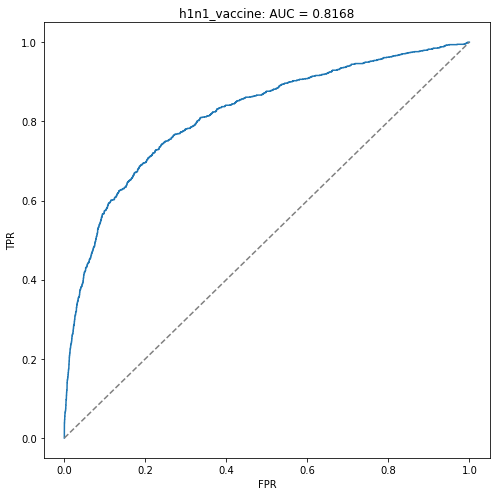

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval_h1n1, 
    XGBR_h1n1_pred, 
    'h1n1_vaccine',
    ax=ax
)
# plot_roc(
#     y_eval['seasonal_vaccine'], 
#     y_preds['seasonal_vaccine'], 
#     'seasonal_vaccine',
#     ax=ax[1]
# )
fig.tight_layout()

### CatBoost

In [7]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 5.1 kB/s 


In [8]:
from catboost import CatBoostClassifier, Pool

In [12]:
  # split features in numeric and categorical
  numeric_cols = features_df.columns[features_df.dtypes != "object"].values
  object_cols = features_df.columns[features_df.dtypes == "object"].values
  # impute data
  features_num_imputed = features_df[numeric_cols].fillna(features_df.median(),inplace=False)
  features_obj_imputed = features_df[object_cols].fillna(features_df.mode().iloc[0])

  features_imputed = pd.merge(features_num_imputed, features_obj_imputed, how='inner', on='respondent_id')

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features_imputed, labels_df, test_size=0.3, random_state=68)

categorical_features_indices = np.where(features_imputed.dtypes != float)[0]
categorical_features_indices

array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [46]:
# Initialize model
catBoostmodel = CatBoostClassifier(verbose=False,
    cat_features=categorical_features_indices,
    iterations=500,
    learning_rate=0.05745075659543725,
    random_strength=4,
    bagging_temperature=8,
    max_bin=5,
    grow_policy='Lossguide',
    min_data_in_leaf=7,
    max_depth=6,
    l2_leaf_reg=11.323094517862078,
    one_hot_max_size=10,
    auto_class_weights='Balanced')

In [47]:
catBoostmodel.fit(X_train, y_train.h1n1_vaccine)

In [69]:
pred_h1n1 = catBoostmodel.predict_proba(X_test)

In [70]:
pred_h1n1

array([[0.66839332, 0.33160668],
       [0.61925204, 0.38074796],
       [0.76705262, 0.23294738],
       ...,
       [0.92174797, 0.07825203],
       [0.44563856, 0.55436144],
       [0.64284364, 0.35715636]])

In [71]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)

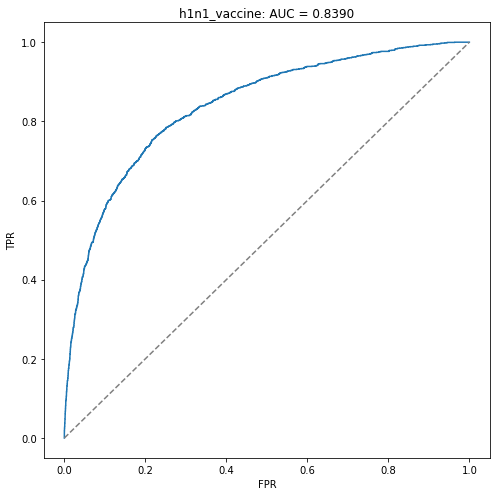

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_test.h1n1_vaccine, 
    pred_h1n1, 
    'h1n1_vaccine',
    ax=ax
)

fig.tight_layout()

## Hyperparameter optimization
optimize he hyperparameters with Optuna

In [ ]:
!pip install --quiet optuna

     |████████████████████████████████| 301 kB 4.2 MB/s 
     |████████████████████████████████| 80 kB 4.4 MB/s 
     |████████████████████████████████| 164 kB 6.6 MB/s 
     |████████████████████████████████| 75 kB 2.6 MB/s 
     |████████████████████████████████| 111 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 3.9 MB/s 
     |████████████████████████████████| 141 kB 7.6 MB/s 


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

optuna.__version__

'2.8.0'

In [ ]:
def objective(trial):
#    iris = sklearn.datasets.load_iris()
    
    n_estimators = trial.suggest_int('n_estimators', 1000, 1500, step=100)
    max_depth = trial.suggest_int('max_depth', 2, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2)
    
    # clf = RandomForestRegressor(
    #     n_estimators=n_estimators, max_depth=max_depth)
    clf = XGBRegressor(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, verbosity=1, objective='reg:squarederror')
    
    return cross_val_score(
        clf, X_train_h1n1, y_train_h1n1, scoring='roc_auc', n_jobs=-1, cv=5).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

trial = study.best_trial

print('ROC_AUC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-07-20 15:45:53,242] A new study created in memory with name: no-name-2126b73d-3ba3-4c78-8fe9-78771b11906e
[I 2021-07-20 15:50:20,087] Trial 0 finished with value: 0.804353767278975 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'learning_rate': 0.11923231523170506}. Best is trial 0 with value: 0.804353767278975.
[I 2021-07-20 15:52:07,235] Trial 1 finished with value: 0.8381314060048914 and parameters: {'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.11332581099034476}. Best is trial 1 with value: 0.8381314060048914.
[I 2021-07-20 15:53:54,052] Trial 2 finished with value: 0.8369627233069457 and parameters: {'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.16482246449800037}. Best is trial 1 with value: 0.8381314060048914.
[I 2021-07-20 15:59:06,696] Trial 3 finished with value: 0.8147543294410993 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'learning_rate': 0.06754572389595728}. Best is trial 1 with value: 0.8381314060048914.
[I 2021-07-20 16

ROC_AUC: 0.8381314060048914
Best hyperparameters: {'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.11332581099034476}


In [ ]:
# Random Forest
# Accuracy: 0.8260519172978962; 
# Best hyperparameters: {'n_estimators': 450, 'max_depth': 5}

In [ ]:
np.negative(cross_val_score(regr_h1n1, X_train_h1n1, y_train_h1n1, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3))

array([0.35633913, 0.35157226, 0.3472993 ])

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

## Submission

In [ ]:
def get_submission(predictor_h1n1, predictor_seasonal, test_features, path):
  '''
    Takes one fitted regressor per target value (h1n1 and seasonal_flue) and creates submission file with time stamp.
  '''
    # Predict
  pred_h1n1 = predictor_h1n1.predict(test_features)
  pred_seasonal = predictor_seasonal.predict(test_features)

  # Create submission file
  predictions = np.stack([test_df.index.values, pred_h1n1, pred_seasonal], axis=1)
  print('Save submission file to Drive...')
  path = path+'submissions/'
  timestr = time.strftime("%d_%m_%Y__%H_%M_%S")
  filename = path + timestr + '.csv'
  np.savetxt(filename, predictions, delimiter=',', header="respondent_id, h1n1_vaccine, seasonal_vaccine", comments="")
  print('Submission saved! \n Path to file: '+ filename)

In [ ]:
get_submission(predictor_h1n1=regr_h1n1, predictor_seasonal=regr_seasonal, test_features=features_test,path=path)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Save submission file to Drive...
Submission saved! 
 Path to file: /content/drive/MyDrive/Flu_challenge/Predict-H1N1-and-Seasonal-Flu-Vaccines/data/submissions/16_07_2021__11_10_22.csv


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished


In [ ]:
# XGradientBoost submission
get_submission(predictor_h1n1=XGBR_h1n1, predictor_seasonal=XGBR_seasonal, test_features=features_test, path=path)

Save submission file to Drive...
Submission saved! 
 Path to file: /content/drive/MyDrive/Flu_challenge/Predict-H1N1-and-Seasonal-Flu-Vaccines/data/submissions/20_07_2021__17_30_05.csv


Mögliche To Dos:

- Aufteilen der Features in h1n1-relevant und seasonal-relevant
- Grid search über einige Parameter des RandomForest und GradientBoost
- Weiteren Ansatz testen?

Christian:
- Code um verschiedene Funktionen durchzusetzen

## Training

In [ ]:
estimators = MultiOutputClassifier(
    estimator=RandomForestRegressor()
)

In [ ]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [ ]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)
preds

AttributeError: ignored

In [ ]:
print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

test_probas[0].shape (8814, 2)
test_probas[1].shape (8814, 2)


In [ ]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.291010,0.472780
16516,0.097770,0.381615
3106,0.155402,0.629756
16981,0.661791,0.857876
19111,0.284478,0.776927


In [ ]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

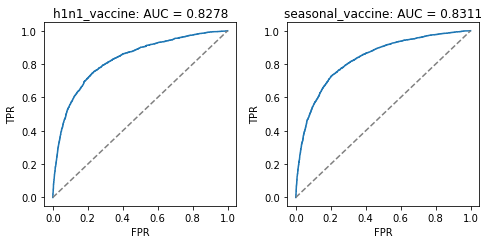

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [ ]:
roc_auc_score(y_eval, y_preds)

0.8294712007285718